# Homework 5

## Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
import warnings
warnings.filterwarnings('ignore')

### 1. Read the csv file from the URL and set the first column in the data as the index column.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/US_macro_Quarterly.csv')
df.set_index(df.columns[0], inplace=True)
df.index.name = 'date'
df.head()

realgdp  realcons  realinv  realgovt  realdpi    cpi     m1  \
date                                                                       
1959-03-31  2710.349    1707.4  286.898   470.045   1886.9  28.98  139.7   
1959-06-30  2778.801    1733.7  310.859   481.301   1919.7  29.15  141.7   
1959-09-30  2775.488    1751.8  289.226   491.260   1916.4  29.35  140.5   
1959-12-31  2785.204    1753.7  299.356   484.052   1931.3  29.37  140.0   
1960-03-31  2847.699    1770.5  331.722   462.199   1955.5  29.54  139.6   

            tbilrate  unemp      pop  infl  realint  
date                                                 
1959-03-31      2.82    5.8  177.146  0.00     0.00  
1959-06-30      3.08    5.1  177.830  2.34     0.74  
1959-09-30      3.82    5.3  178.657  2.74     1.09  
1959-12-31      4.33    5.6  179.386  0.27     4.06  
1960-03-31      3.50    5.2  180.007  2.31     1.19

### 2. Before moving forward, we first need to change the data frame index type into "datetime"?

In [ ]:
df.index = pd.to_datetime(df.index).to_period('Q')
df.head()

realgdp  realcons  realinv  realgovt  realdpi    cpi     m1  \
date                                                                   
1959Q1  2710.349    1707.4  286.898   470.045   1886.9  28.98  139.7   
1959Q2  2778.801    1733.7  310.859   481.301   1919.7  29.15  141.7   
1959Q3  2775.488    1751.8  289.226   491.260   1916.4  29.35  140.5   
1959Q4  2785.204    1753.7  299.356   484.052   1931.3  29.37  140.0   
1960Q1  2847.699    1770.5  331.722   462.199   1955.5  29.54  139.6   

        tbilrate  unemp      pop  infl  realint  
date                                             
1959Q1      2.82    5.8  177.146  0.00     0.00  
1959Q2      3.08    5.1  177.830  2.34     0.74  
1959Q3      3.82    5.3  178.657  2.74     1.09  
1959Q4      4.33    5.6  179.386  0.27     4.06  
1960Q1      3.50    5.2  180.007  2.31     1.19

### 3. Our variable of interest is "cpi" which stands for consumer price index. Keep this variable in the data and drop the rest.

In [4]:
df = df[['cpi']]
df.head()

cpi
date         
1959Q1  28.98
1959Q2  29.15
1959Q3  29.35
1959Q4  29.37
1960Q1  29.54

### 4. Using Matplotlib, plot the time series for cpi. As you can see, the cpi data is NOT stationary. what are the implications if we apply the decision tree or random forest models from sklearn to this data without preprocessing it? preprocessing simply means, transforming, detrending, deseasonalizing the data if needed.

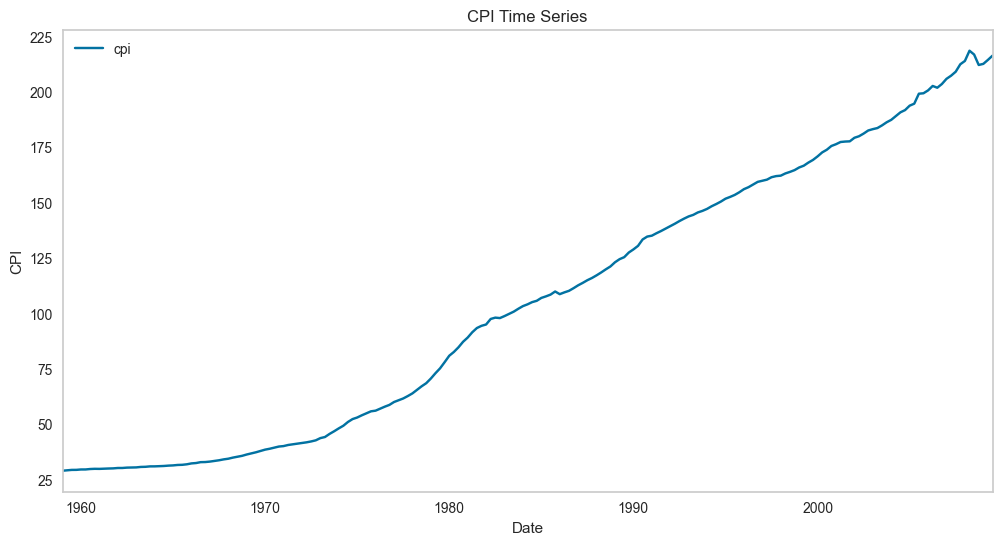

In [5]:
df.plot(figsize=(12,6))
plt.title('CPI Time Series')
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

4. (Answer) - If we feed the data to a random forest model unprocessed, then because of the clear trend, it will probably perform quite poorly on the test set. If the tree is deep enough, it can perform "perfectly" on the train set, but It will most likely fail in the test set.

### 5. Prepare your dataset for a supervised machine learning task by adding 3 lags to the data set.

In [6]:
series = df['cpi'].dropna().to_numpy()

lag1 = np.roll(series, 1)
lag1[0] = np.nan

lag2 = np.roll(series, 2)
lag2[:2] = np.nan

lag3 = np.roll(series, 3)
lag3[:3] = np.nan

df['lag-1'] = lag1
df['lag-2'] = lag2
df['lag-3'] = lag3

df.head()

cpi  lag-1  lag-2  lag-3
date                              
1959Q1  28.98    NaN    NaN    NaN
1959Q2  29.15  28.98    NaN    NaN
1959Q3  29.35  29.15  28.98    NaN
1959Q4  29.37  29.35  29.15  28.98
1960Q1  29.54  29.37  29.35  29.15

### 6. Prepare the train and test set:
* #### Split the data into train and test. Keep the last 24 observations in the test set and the rest in train set. Specify your features X and target variable y. What is the shape of your df_train and df_test sets?
* #### Why can't you use train_test_split() function from sklearn here? what's wrong with that approach?

In [7]:
test_size = 24
train_size = len(df) - test_size

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

train_indicator[:3] = False

X = np.array(df[['lag-1', 'lag-2', 'lag-3']])
Y = np.array(df[['cpi']])

Xtrain, Ytrain = X[3:-test_size], Y[3:-test_size]
Xtest, Ytest = X[-test_size:], Y[-test_size:]

df.loc[train_indicator, 'train_set'] = df.loc[train_indicator, 'cpi']
df.loc[test_indicator, 'test_set'] = df.loc[test_indicator, 'cpi']

In [8]:
print(train.shape, test.shape)

(179, 4) (24, 4)


6. (Answer) - The train set contains 179 observations of 3 features and one target; and the test set contains 24 observations of 3 features and one target. We can't use `train_test_split()` because it shuffles the data, which defeats the time-series purpose.

### 7. Train a simple decision tree model with max depth = 10 and report the MAPE in the train set? Does this mean that your model is complex enough? can the model overfit the data?

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(Xtrain, Ytrain)

DecisionTreeRegressor(max_depth=10)

In [10]:
preds = dt_model.predict(Xtrain)
df.loc[train_indicator, '1step_train_forecast'] = preds

mape_train = mean_absolute_percentage_error(Ytrain, preds)
print("Train Set MAPE:",mape_train)

Train Set MAPE: 0.0


7. (Answer) - The MAPE is 0. This means that our model has almost assuredly overfit the data, which is a good thing, as it means our model is complex enough.

### 8. Now we need to make some forecasts in the test set (the last 24 observations, this is what PyCaret calls hold out set).
* #### Why we cannot use something like the following for multi-step forecasts: y_test_pred = dt_model.predict(X_test). What's wrong with this approach?
* #### The correct way is to create a forecast_future function (as we did in class) and make predictions into future using the past predictions. Go ahead and create your forecast_future function and report the MAPE in the test set now.

In [11]:
test_preds = []

input_X = Xtest[0]

while len(test_preds) < test_size:
  prediction = dt_model.predict(input_X.reshape(1, -1))[0]
  test_preds.append(prediction)

  input_X = np.roll(input_X, -1)
  input_X[-1] = prediction

mape_test = mean_absolute_percentage_error(Ytest, test_preds)
print("Test Set MAPE:",mape_test)

df.loc[test_indicator, '1step_test_forecast'] = test_preds
df.tail()


Test Set MAPE: 0.08872469814856854


cpi    lag-1    lag-2    lag-3  train_set  test_set  \
date                                                              
2008Q3  216.889  218.610  213.997  212.495        NaN   216.889   
2008Q4  212.174  216.889  218.610  213.997        NaN   212.174   
2009Q1  212.671  212.174  216.889  218.610        NaN   212.671   
2009Q2  214.469  212.671  212.174  216.889        NaN   214.469   
2009Q3  216.385  214.469  212.671  212.174        NaN   216.385   

        1step_train_forecast  1step_test_forecast  
date                                               
2008Q3                   NaN                184.9  
2008Q4                   NaN                184.9  
2009Q1                   NaN                184.9  
2009Q2                   NaN                184.9  
2009Q3                   NaN                184.9

8. (Answer) - Similar to the reason we can't use `train_test_split()`, we can't use `model.predict()` because it doesn't account for the sequential dependencies of the time-series data.

### 9. Plot the actuals vs predictions for train and test set in one figure! why is your decision tree performing poorly in the test set?

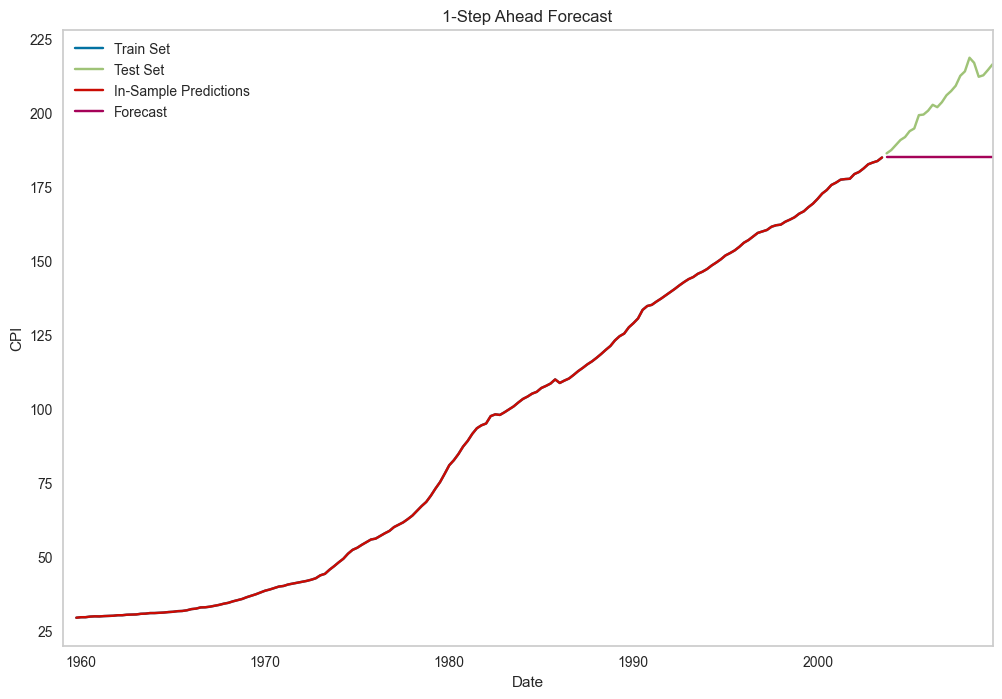

In [12]:
df[['train_set', 'test_set', '1step_train_forecast', '1step_test_forecast']].plot(figsize=(12, 8))
plt.title('1-Step Ahead Forecast')
plt.legend(['Train Set', 'Test Set', 'In-Sample Predictions', 'Forecast'])
plt.grid(visible=False)
plt.xlabel("Date")
plt.ylabel("CPI")
plt.show()

9. (Answer) - the models performance is abysmal because we did not preprocess it, and decision trees aren't great at handling non-stationary time-series.

P.S. Sorry I don't know why the colors are atrocious for this graph...

### 10. As you can see in the figure above, the performance of our machine learning model in the test set is very bad! one solution is to make the data stationary and rerun the model. How about differencing the cpi data once and apply the same decision tree model to that? what is your MAPE in the test set now? any progress?

NOTE: Follow these steps
* Go back to original dataset with cpi series. You need to import the csv file again! don't forget to change the index to datetime.
* create a variable named diff_cpi which is simply the first difference of cpi series. 
* create 3 lag variables for diff_cpi. Make sure you drop na values. 
* split the data into train and test. To be consistent with previous part, keep the last 24 observations for test set and the rest for the train set. Create your features X and target y. 
* Train the model on the new X and y
* Make predictions for train set! Be careful! you need to undifference the data in the train set to get back to the actual levels of cpi. 
* Make forecasts for the test set! this is where you need to create your forecast_future function again.  Important: use the last know cpi from the train set and add the forecasted diff_cpi cumulatively to that value in order to get the level forecasts of cpi. 
* Report the MAPE in the test set. 

In [13]:
df2 = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/US_macro_Quarterly.csv')
df2.set_index(df2.columns[0], inplace=True)
df2.index.name = 'date'
df2.index = pd.to_datetime(df2.index).to_period('Q')
df2 = df2[['cpi']]

In [14]:
diff_cpi = np.array(df2['cpi']) - np.roll(np.array(df2['cpi']), 1)
diff_cpi[0] = np.nan
df2['diff_cpi'] = diff_cpi
df2 = df2[1:]
df2.head()

cpi  diff_cpi
date                   
1959Q2  29.15      0.17
1959Q3  29.35      0.20
1959Q4  29.37      0.02
1960Q1  29.54      0.17
1960Q2  29.55      0.01

In [15]:
series = df2['diff_cpi'].dropna().to_numpy()

lag1 = np.roll(series, 1)
lag1[0] = np.nan

lag2 = np.roll(series, 2)
lag2[:2] = np.nan

lag3 = np.roll(series, 3)
lag3[:3] = np.nan


df2['lag-1'] = lag1
df2['lag-2'] = lag2
df2['lag-3'] = lag3

initial_cpi = df2['cpi'][2]
df2.head()

cpi  diff_cpi  lag-1  lag-2  lag-3
date                                        
1959Q2  29.15      0.17    NaN    NaN    NaN
1959Q3  29.35      0.20   0.17    NaN    NaN
1959Q4  29.37      0.02   0.20   0.17    NaN
1960Q1  29.54      0.17   0.02   0.20   0.17
1960Q2  29.55      0.01   0.17   0.02   0.20

In [16]:
test_size = 24
train_size = len(df2) - test_size

train = df2.iloc[:train_size]
test = df2.iloc[train_size:]

train_indicator = (df2.index <= train.index[-1])
test_indicator =  (df2.index > train.index[-1])

train_indicator[:3] = False

X = np.array(df2[['lag-1', 'lag-2', 'lag-3']])
Y = np.array(df2[['diff_cpi']])

Xtrain, Ytrain = X[3:-test_size], Y[3:-test_size]
Xtest, Ytest = X[-test_size:], Y[-test_size:]

df2.loc[train_indicator, 'train_set'] = df2.loc[train_indicator, 'cpi']
df2.loc[test_indicator, 'test_set'] = df2.loc[test_indicator, 'cpi']

In [17]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(Xtrain, Ytrain)

DecisionTreeRegressor(max_depth=10)

In [18]:
preds = dt_model.predict(Xtrain)

pred_cpi = []
for i in range(len(preds)):
    prediction = df2['cpi'][i+2] + preds[i]
    pred_cpi.append(prediction)

df2.loc[train_indicator, '1step_train_forecast'] = pred_cpi

mape_train = mean_absolute_percentage_error(df2.loc[train_indicator,'cpi'], df2.loc[train_indicator,'1step_train_forecast'])
print("Train Set MAPE:",mape_train)

df2.head()

Train Set MAPE: 0.0004368547212117046


cpi  diff_cpi  lag-1  lag-2  lag-3  train_set  test_set  \
date                                                                
1959Q2  29.15      0.17    NaN    NaN    NaN        NaN       NaN   
1959Q3  29.35      0.20   0.17    NaN    NaN        NaN       NaN   
1959Q4  29.37      0.02   0.20   0.17    NaN        NaN       NaN   
1960Q1  29.54      0.17   0.02   0.20   0.17      29.54       NaN   
1960Q2  29.55      0.01   0.17   0.02   0.20      29.55       NaN   

        1step_train_forecast  
date                          
1959Q2                   NaN  
1959Q3                   NaN  
1959Q4                   NaN  
1960Q1                 29.49  
1960Q2                 29.55

In [19]:
test_preds = []

input_X = Xtest[0]

while len(test_preds) < test_size:
  prediction = dt_model.predict(input_X.reshape(1, -1))[0]
  test_preds.append(prediction)

  input_X = np.roll(input_X, -1)
  input_X[-1] = prediction

initial_prediction = test_preds[0] + df2['cpi'][train_size]
test_pred_cpi = [initial_prediction]
for i in range(1,len(test_preds)):
    prediction = test_pred_cpi[i-1] + test_preds[i]
    test_pred_cpi.append(prediction)

df2.loc[test_indicator, '1step_test_forecast'] = test_pred_cpi
df2.tail()

cpi  diff_cpi  lag-1  lag-2  lag-3  train_set  test_set  \
date                                                                  
2008Q3  216.889    -1.721  4.613  1.502  3.362        NaN   216.889   
2008Q4  212.174    -4.715 -1.721  4.613  1.502        NaN   212.174   
2009Q1  212.671     0.497 -4.715 -1.721  4.613        NaN   212.671   
2009Q2  214.469     1.798  0.497 -4.715 -1.721        NaN   214.469   
2009Q3  216.385     1.916  1.798  0.497 -4.715        NaN   216.385   

        1step_train_forecast  1step_test_forecast  
date                                               
2008Q3                   NaN               199.15  
2008Q4                   NaN               200.05  
2009Q1                   NaN               200.15  
2009Q2                   NaN               201.15  
2009Q3                   NaN               202.05

In [20]:
mape_test = mean_absolute_percentage_error(df2.loc[test_indicator,'cpi'], df2.loc[test_indicator,'1step_test_forecast'])
print("Test Set MAPE:",mape_test)

Test Set MAPE: 0.04448819604338389


10. (Answer) - The test-set MAPE is now 0.0445 compared to the 0.0889 previously. A 50% decrease in MAPE is not negligible, but there's still a ways to go.

### 11. Great job, now visualize the actuals vs predictions both in the train and test set!

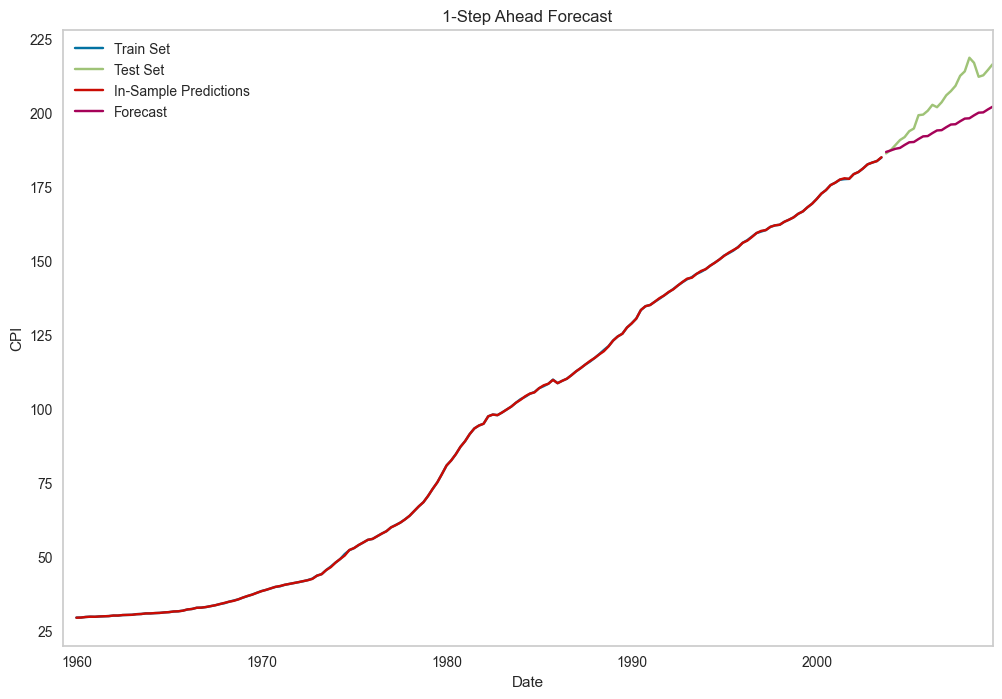

In [21]:
df2[['train_set', 'test_set', '1step_train_forecast', '1step_test_forecast']].plot(figsize=(12, 8))
plt.title('1-Step Ahead Forecast')
plt.legend(['Train Set', 'Test Set', 'In-Sample Predictions', 'Forecast'])
plt.grid(visible=False)
plt.xlabel("Date")
plt.ylabel("CPI")
plt.show()

### 12. You tried so hard to get here, now you deserve to sit back and enjoy doing all the econometrics and ML models in PyCaret. Pycaret is taking care of everything (I mean everything you did above) in couple of lines :)

* set up your pycaret experiment:  Hint: exp = setup(data = df, target = 'cpi', fh = 24, session_id=1000)
* run a horse race between all the timeseries models in pycaret. Make sure to set the cross validation = False, to get a fair comparison in the test set only. Hint: exp.compare_models(cross_validation=False)
* Which family of models are winning this competition? Econometrics models or ML models? :)

In [22]:
from pycaret.time_series import *
exp = TSForecastingExperiment()

df3 = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/US_macro_Quarterly.csv')
df3.set_index(df3.columns[0], inplace=True)
df3.index.name = 'date'
df3.index = pd.to_datetime(df3.index).to_period('Q')
df3 = df3[['cpi']]

exp.setup(data=df3, target='cpi', fh=24, session_id=1000)

In [23]:
exp.compare_models()

ExponentialSmoothing(seasonal='mul', sp=3, trend='add')

12. (Answer) - The Econometrics models are winning this race here, Which is surprising to me, since The cpi doesn't seem to exhibit a well-behaved tendency.

## Question 2

In [24]:
stocks = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv', index_col=0, header=[0,1])
stocks.index = pd.to_datetime(stocks.index).to_period('B')
stocks.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.722874  125.150002  80.229012  152.072800  243.072266   
2018-01-03  40.715786  124.820000  80.602394  153.550400  244.609711   
2018-01-04  40.904907  125.459999  81.311806  153.819046  245.640732   
2018-01-05  41.370617  125.330002  82.319908  155.363861  247.277679   
2018-01-08  41.216949  125.309998  82.403923  155.968399  247.729935   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

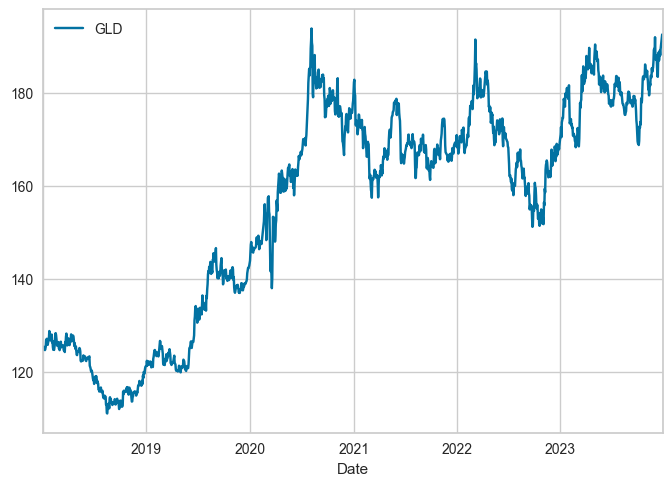

In [25]:
df = stocks['Close'][['GLD']]
df.plot()
plt.show()

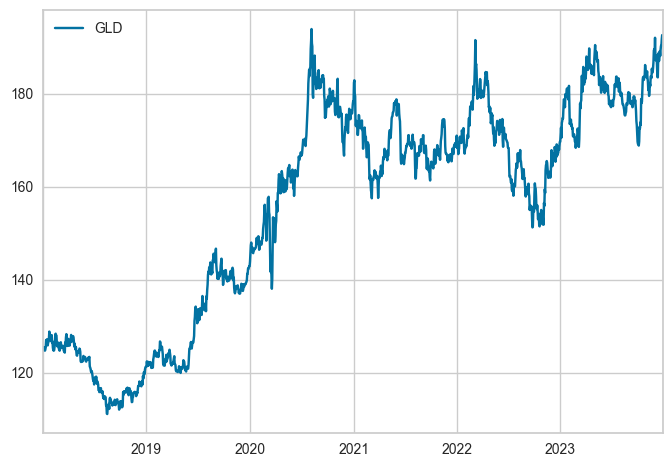

In [26]:
idx = pd.period_range(min(df.index), max(df.index))
df = df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')

df.plot()
plt.show()

In [27]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

exp = TSForecastingExperiment()
exp.setup(data=df, target='GLD', coverage=0.9, fold_strategy=SlidingWindowSplitter(fh=np.arange(1,23), window_length=130, step_length=130), session_id=1000)

In [28]:
exp.plot_model(plot='train_test_split')

In [29]:
exp.plot_model(plot='cv')

In [30]:
exp.compare_models(sort='mape')

ExponentialSmoothing(sp=1, trend='add')

In [31]:
ets = exp.create_model('ets')
tuned_ets = exp.tune_model(ets)

Fitting 11 folds for each of 6 candidates, totalling 66 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    0.2s finished


ETS once again is the winner. Interestingly enough, KNN untuned was only 0.005 off on MAPE. but ETS is definitely the winner, barely edging out the random walk. Sheesh. Forecasting really is hard

In [32]:
arima = exp.create_model('arima')
tuned_arima = exp.tune_model(arima)

Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.5s finished


Arima can't keep up with ETS, and is actually the worst of the four models considered.

In [33]:
xgboost = exp.create_model('xgboost_cds_dt', window_length=7)
tuned_xgboost = exp.tune_model(xgboost)

Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    2.9s finished


xgboost just can't quite hang with the best of the econometrics models, shame... It does however outperform the arima models, so that's a plus.

I played around with the window_length and found that a value of 7 produced the lowest MAPE, but it still doesn't compete with ETS

In [34]:
knn = exp.create_model('knn_cds_dt')
tuned_knn = exp.tune_model(knn)

Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.4s finished


Interestingly, KNN seems to do worse after it is tuned...

In [35]:
exp.plot_model(estimator=tuned_ets, plot="diagnostics")

In [36]:
exp.plot_model(estimator=tuned_ets, plot="insample")

In [37]:
exp.plot_model(tuned_ets, plot='forecast', data_kwargs={'fh':36})

In [38]:
holdout_predictions = exp.predict_model(tuned_ets)

In [39]:
finalized_ets = exp.finalize_model(tuned_ets)
exp.plot_model(finalized_ets, plot='forecast', data_kwargs={'fh':24})

In [40]:
unseen_predictions = exp.predict_model(finalized_ets, fh=10)
unseen_predictions

y_pred
2024-01-01  191.2193
2024-01-02  191.2686
2024-01-03  191.3179
2024-01-04  191.3672
2024-01-05  191.4165
2024-01-08  191.4658
2024-01-09  191.5151
2024-01-10  191.5644
2024-01-11  191.6137
2024-01-12  191.6630

As shown above, the ETS model of the econometrics family outperformed all the other models, barely beating the random walk.